In [2]:
# sky_tests.ipynb
# Authors: Stephan Meighen-Berger
# Some kmeans tests

In [64]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pickle
import csv
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
from sklearn.cluster import KMeans
import ephem
from kneed import KneeLocator

In [4]:
# picture path
PICS = '../pics/'

In [5]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [6]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.
mark_s = 10
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [7]:
# Constants
minutes = 60.
days = 60. * 24

In [8]:
def ice_parser(filename):
    store = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row_num, row in enumerate(reader):
            if row_num == 0:
                continue
            store.append(row[0].split())
    store = np.array(store, dtype=float)
    return store
# log10(E_nu/GeV)_min, log10(E_nu/GeV)_max, Dec_nu_min[deg], Dec_nu_max[deg], A_Eff[cm^2]
eff_areas = [
    '../data/icecube_10year_ps/irfs/IC40_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC59_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC79_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC86_I_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_effectiveArea.csv',
]
eff_dic = {
    0: ice_parser(eff_areas[0]),
    1: ice_parser(eff_areas[1]),
    2: ice_parser(eff_areas[2]),
    3: ice_parser(eff_areas[3]),
    4: ice_parser(eff_areas[4]),
    5: ice_parser(eff_areas[4]),
    6: ice_parser(eff_areas[4]),
    7: ice_parser(eff_areas[4]),
    8: ice_parser(eff_areas[4]),
    9: ice_parser(eff_areas[4]),
}

In [9]:
# MJD, log10(E/GeV), AngErr[deg], RA[deg], Dec[deg], Azimuth[deg], Zenith[deg]
data_sets = [
    '../data/icecube_10year_ps/events/IC40_exp.csv',
    '../data/icecube_10year_ps/events/IC59_exp.csv',
    '../data/icecube_10year_ps/events/IC79_exp.csv',
    '../data/icecube_10year_ps/events/IC86_I_exp.csv',
    '../data/icecube_10year_ps/events/IC86_II_exp.csv',
    '../data/icecube_10year_ps/events/IC86_III_exp.csv',
    '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
    '../data/icecube_10year_ps/events/IC86_V_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
]
event_dic = {
    0: ice_parser(data_sets[0]),
    1: ice_parser(data_sets[1]),
    2: ice_parser(data_sets[2]),
    3: ice_parser(data_sets[3]),
    4: ice_parser(data_sets[4]),
    5: ice_parser(data_sets[5]),
    6: ice_parser(data_sets[6]),
    7: ice_parser(data_sets[7]),
    8: ice_parser(data_sets[8]),
    9: ice_parser(data_sets[9]),
}

In [10]:
# MJD, log10(E/GeV), AngErr[deg], RA[deg], Dec[deg], Azimuth[deg], Zenith[deg]
uptime_sets = [
    '../data/icecube_10year_ps/uptime/IC40_exp.csv',
    '../data/icecube_10year_ps/uptime/IC59_exp.csv',
    '../data/icecube_10year_ps/uptime/IC79_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_I_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_II_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_III_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_IV_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_V_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_VI_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_VII_exp.csv',
]
uptime_dic = {
    0: ice_parser(uptime_sets[0]),
    1: ice_parser(uptime_sets[1]),
    2: ice_parser(uptime_sets[2]),
    3: ice_parser(uptime_sets[3]),
    4: ice_parser(uptime_sets[4]),
    5: ice_parser(uptime_sets[5]),
    6: ice_parser(uptime_sets[6]),
    7: ice_parser(uptime_sets[7]),
    8: ice_parser(uptime_sets[8]),
    9: ice_parser(uptime_sets[9]),
}
uptime_tot_dic = {}
for year in range(10):
    uptime_tot_dic[year] = np.sum(np.diff(uptime_dic[year])) * days

In [11]:
# Loading smearing
# log10(E_nu/GeV)_min, log10(E_nu/GeV)_max, Dec_nu_min[deg], Dec_nu_max[deg], log10(E/GeV), PSF_min[deg], PSF_max[deg],
# AngErr_min[deg], AngErr_max[deg], Fractional_Counts
smearing_sets = [
    '../data/icecube_10year_ps/irfs/IC40_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC59_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC79_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_I_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
]
smearing_dic = {
    0: ice_parser(smearing_sets[0]),
    1: ice_parser(smearing_sets[1]),
    2: ice_parser(smearing_sets[2]),
    3: ice_parser(smearing_sets[3]),
    4: ice_parser(smearing_sets[4]),
    5: ice_parser(smearing_sets[5]),
    6: ice_parser(smearing_sets[6]),
    7: ice_parser(smearing_sets[7]),
    8: ice_parser(smearing_sets[8]),
    9: ice_parser(smearing_sets[9]),
}

C:\Users\steph\AppData\Local\Temp/ipykernel_1244/2974763209.py:18: RuntimeWarning: divide by zero encountered in true_divide
  weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])
C:\Users\steph\AppData\Local\Temp/ipykernel_1244/2974763209.py:18: RuntimeWarning: invalid value encountered in true_divide
  weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])


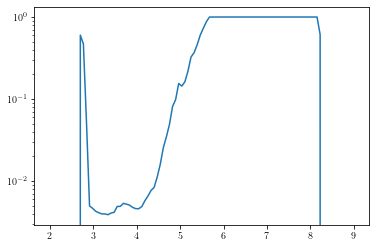

In [12]:
# Loading weights
def weight_constructor(path_to_file: str) -> UnivariateSpline:
    """ constructes the energy weights for the IceCube events

    Parameters
    ----------
    path_to_file : str
        The theoretical preidcitons for the counts

    Returns
    -------
    weights : UnivariateSpline
        Spline which returns the weight corresponding to the input energy
        as log_10(E/GeV)
    """
    theoretical_predictions = pickle.load(open(path_to_file, "rb"))
    egrid = theoretical_predictions[0]
    weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])
    weights_arr[weights_arr > 1] = 1
    return UnivariateSpline(egrid, weights_arr, k=1, s=0)
weights = weight_constructor("..\\data\\simulated_data_bkgrd_store_bckgrd_benchmark.p")
plt.semilogy(np.linspace(2., 9., 100), weights(np.linspace(0., 10., 100)))

In [13]:
def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic

In [14]:
filtered_data = data_filter(event_dic, [4., 9.], [0., 90.], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

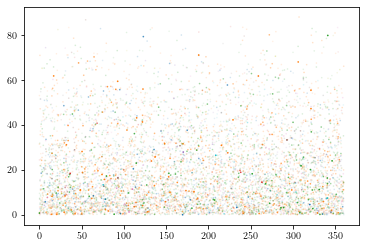

In [15]:
for year in range(10):
    plt.scatter(filtered_data[year][:, 3], filtered_data[year][:, 4], s=0.5, alpha=weights(filtered_data[year][:, 1]))

In [16]:
# Construct weighted events
def weighted_events(event_dic, weight_func, years):
    weighted_data = []
    for year in years:
        weighted_data.append(np.array([
            event_dic[year][:, 3],
            event_dic[year][:, 4],
            weight_func(event_dic[year][:, 1])
        ]))
        weighted_data[-1] = weighted_data[-1].T
    return np.concatenate([weighted_data[year] for year in years])
weighted_data = weighted_events(filtered_data, weights, range(10))

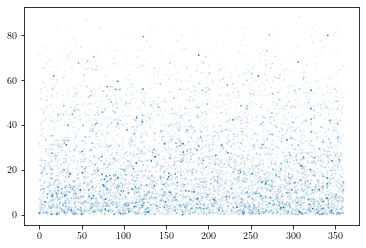

In [17]:
plt.scatter(weighted_data[:, 0], weighted_data[:, 1], s=0.5, alpha=weighted_data[:, 2])

In [18]:
# Modifying data for kmeans
coordinates = weighted_data[:, :2]
event_weights = weighted_data[:, 2]

In [19]:
# Number of events
print(len(event_weights))

6934


In [20]:
# Clustering example
kmeans = KMeans(n_clusters=10, random_state=0)
weighted_fit = kmeans.fit(X=coordinates, sample_weight=event_weights)
predicted_kmeans = kmeans.predict(X=coordinates, sample_weight=event_weights)

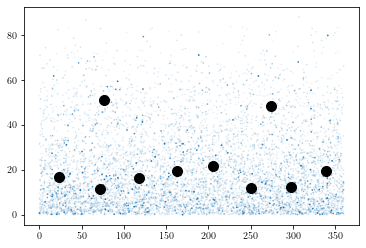

In [21]:
# Plotting kmeans example
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=0.5, alpha=event_weights)
centers = weighted_fit.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=1)

In [22]:
def coordinate_trafo(radians):
    new_grid = np.copy(radians)
    new_grid[new_grid > np.pi] = new_grid[new_grid > np.pi] - 2. * np.pi
    return new_grid

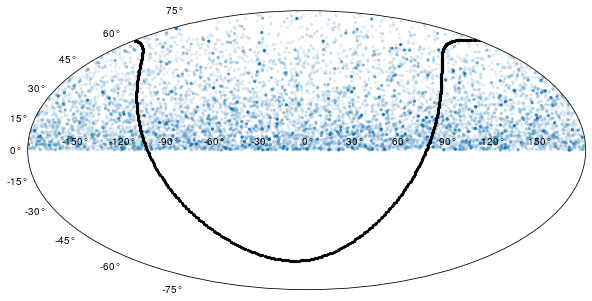

In [78]:
# Using a projection so others have something to look at
fig = plt.figure(figsize=(10, 8))
plt.subplot(projection="mollweide")
traf_RA = coordinate_trafo(np.deg2rad(coordinates[:, 0]))
plt.scatter(traf_RA, np.deg2rad(coordinates[:, 1]), s=5., alpha=event_weights)
# Adding the galactic plane
lon_array = np.arange(0,360)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
gp_ra = -coordinate_trafo(np.deg2rad(eq_array[:,0]))
gp_dec = -np.deg2rad(eq_array[:,1])
plt.scatter(gp_ra, gp_dec, color='k', s=5)
plt.savefig("..\\pics\\skymap.png", dpi=100)

In [71]:
# Finding the optimal number of clusters from the weighted data
# Here the elbow method is used
wcss = []
seeds = np.arange(1000)
for i in tqdm(seeds):
    try:
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        max_iter=300, n_init=10, random_state=0)
        weighted_fit = kmeans.fit(X=coordinates, sample_weight=event_weights)
        wcss.append(kmeans.inertia_)
    except:
        wcss.append(1e10)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\steph\Anaconda3\envs\dmpoint\lib\site-packages\sklearn\cluster\_kmeans.py:94: RuntimeWarning: divide by zero encountered in log
  n_local_trials = 2 + int(np.log(n_clusters))
100%|██████████| 1000/1000 [2:50:05<00:00, 10.21s/it]


In [72]:
kneedle = KneeLocator(seeds, wcss, S=1.0, curve="concave", direction="decreasing")
print(kneedle.elbow)

999


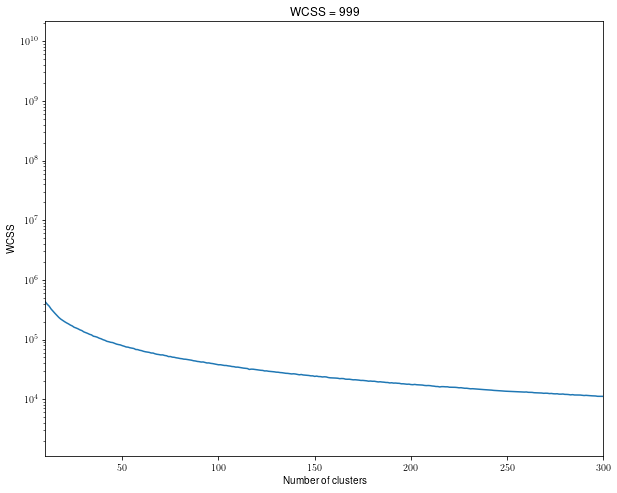

In [84]:
# Plotting the measure
fig = plt.figure(figsize=(10, 8))
plt.semilogy(seeds, wcss)
plt.axvline(kneedle.elbow, color='k', lw=3)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xlim(10, 300)
plt.title("WCSS = %d" %kneedle.elbow)
plt.savefig("..\\pics\\WCSS.png", dpi=100)

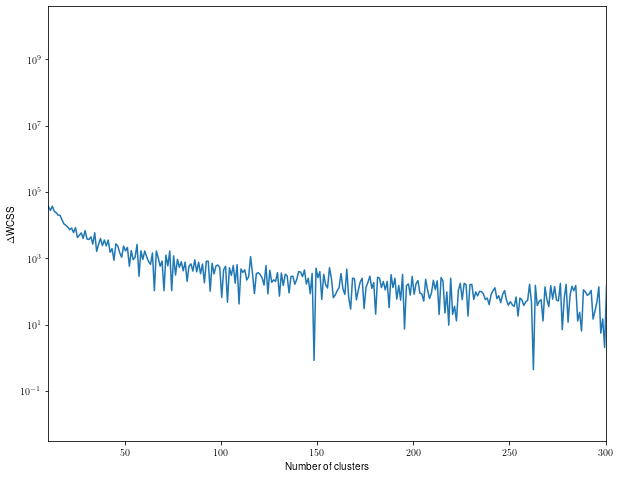

In [83]:
# Plotting the measure
fig = plt.figure(figsize=(10, 8))
plt.semilogy(seeds[:-1] + np.diff(seeds) / 2., np.abs(np.diff(wcss)))
plt.xlabel('Number of clusters')
plt.ylabel(r'$\Delta$WCSS')
plt.xlim(10, 300)
plt.savefig("..\\pics\\Differential_WCSS.png", dpi=100)